## Import Libraries

In [52]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers , models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16 , ResNet50 , ConvNeXtBase
import matplotlib.pyplot as plt

In [54]:
folder_name = 'Quantum_Converted'
height = 256
width = 256
channels  = 3
format = 'rgb' # Image Format

### Create train dataset

In [4]:
df = pd.DataFrame(data= None , columns= ['label' , 'filename'])
dataset_path = os.getcwd().replace('notebook' , '') + folder_name
count = 0
for folder in [i for i in os.listdir(dataset_path) if i not in ['.DS_Store' , 'label.csv']]:
    for i , file in enumerate(os.listdir(dataset_path + '/' + folder)):
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                  df.loc[count + i] = [folder, file]
            count += len(os.listdir(dataset_path + '/' + folder))
df.to_csv(os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv')

## Pre Processing

In [5]:
label_df_path = os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv' 
df = pd.read_csv(label_df_path , index_col=0)

# One Hot Encode genre file
df_encoded = pd.get_dummies(df['label'], columns=['label'])

y = df_encoded.values

### Metric Visualisation

In [6]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['categorical_accuracy'])
  plt.plot(epochRange,history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

## Modelling

### VGG16

#### Image Processing

In [29]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)
# x = core(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:02<00:00, 229.49it/s]


### Tranfer Learning weights freezed

In [47]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │   134,221,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,738,309 (632.24 MB)

 Trainable params: 151,023,621 (576.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [42]:
est = model.fit(x_train,y_train , epochs=20 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - categorical_accuracy: 0.2029 - loss: 2.3177 - val_categorical_accuracy: 0.3109 - val_loss: 1.8251
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - categorical_accuracy: 0.3622 - loss: 1.6333 - val_categorical_accuracy: 0.4370 - val_loss: 1.4564
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - categorical_accuracy: 0.5108 - loss: 1.3159 - val_categorical_accuracy: 0.4958 - val_loss: 1.2464
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - categorical_accuracy: 0.5643 - loss: 1.1645 - val_categorical_accuracy: 0.5714 - val_loss: 1.1274
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - categorical_accuracy: 0.5944 - loss: 1.0165 - val_categorical_accuracy: 0.6050 - val_loss: 1.0455
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - categorical_accuracy: 0.6640 - loss: 0.8857 - val_categorical_accuracy: 0.6218 - val_loss: 1.0027
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - categorical_accuracy: 0.7103 - loss: 0.7963 - va

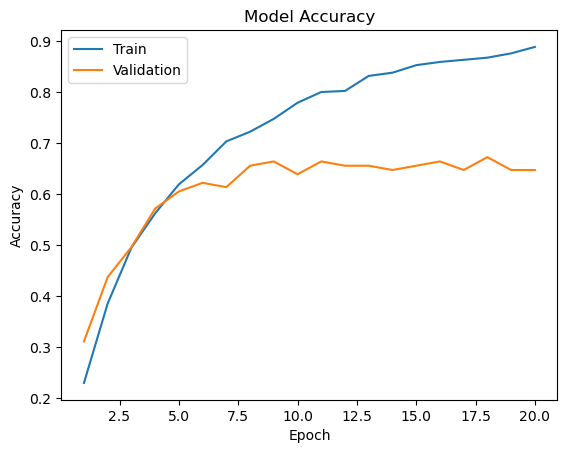

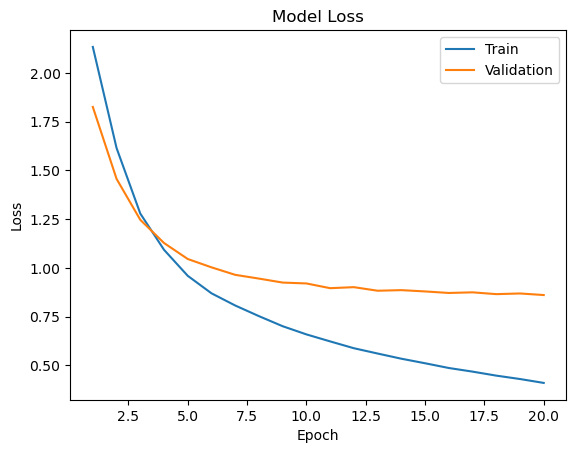

In [44]:
plotLearningCurve(est,20)

### ResNet50

#### Image Preprocessing

In [43]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:02<00:00, 218.94it/s]


In [47]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [82]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [83]:
est = model.fit(x_train,y_train , epochs=50 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 953ms/step - categorical_accuracy: 0.4594 - loss: 2.8293 - val_categorical_accuracy: 0.7395 - val_loss: 0.7202
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - categorical_accuracy: 0.8692 - loss: 0.3721 - val_categorical_accuracy: 0.7563 - val_loss: 0.7187
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 919ms/step - categorical_accuracy: 0.9103 - loss: 0.2640 - val_categorical_accuracy: 0.7983 - val_loss: 0.6045
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 914ms/step - categorical_accuracy: 0.9787 - loss: 0.1019 - val_categorical_accuracy: 0.7395 - val_loss: 0.8053
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 891ms/step - categorical_accuracy: 0.9907 - loss: 0.0687 - val_categorical_accuracy: 0.7899 - val_loss: 0.6722
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 882ms/step - categorical_accuracy: 1.0000 - loss: 0.0298 - val_categorical_accuracy: 0.7815 - val_loss: 0.7364
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 881ms/step - categorical_accuracy: 1.000

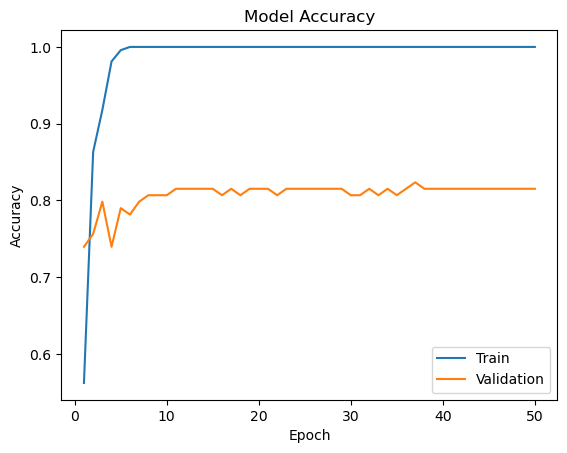

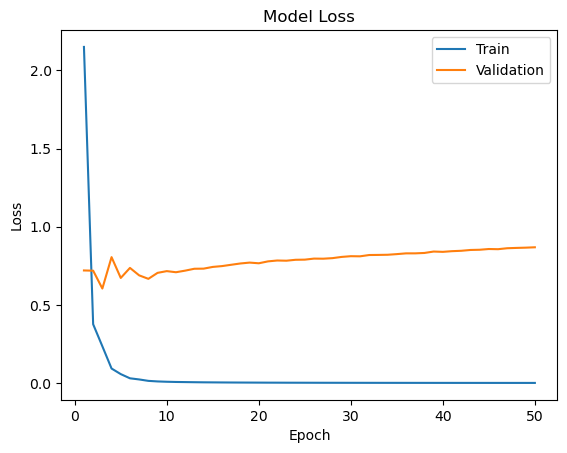

In [85]:
plotLearningCurve(est,50)

### ConvNeXt

#### Image PreProcessing

In [60]:
from tensorflow.keras.applications.convnext import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:02<00:00, 213.13it/s]


In [63]:
base_model = ConvNeXtBase(weights="imagenet", include_top=False, input_shape=(height, width, channels))
model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.LayerNormalization(epsilon=1e-6),
    layers.Dense(1024, activation="gelu"),
    layers.Dense(5, activation='softmax')
])

model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 8, 8, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 1024)           │         2,048 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,623,237 (338.07 MB)

 Trainable params: 88,623,237 (338.07 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
est = model.fit(x_train,y_train , epochs=20 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/50


I0000 00:00:1741103872.693204  251298 service.cc:148] XLA service 0x3fa415a30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741103872.693354  251298 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1741103872.724085  251298 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/15 ━━━━━━━━━━━━━━━━━━━━ 21:32 92s/step - categorical_accuracy: 0.1875 - loss: 1.8947